In [87]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [13]:
from __future__ import print_function
from pixell import enmap
import numpy as np
import matplotlib.pyplot as plt
from pixell import enplot
import scipy
import pymaster as nmt
from astropy.io import ascii

In [55]:
point_source_mask_filename = "data/dr1/mask/car/mask_05.00arcmin_0.015Jy_new_car.fits" 
lmax_beam = 30000
nsplits = 4

# PA 1 -----
beam_filename = "data/from_choi/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"

beam_table = np.loadtxt(beam_filename)

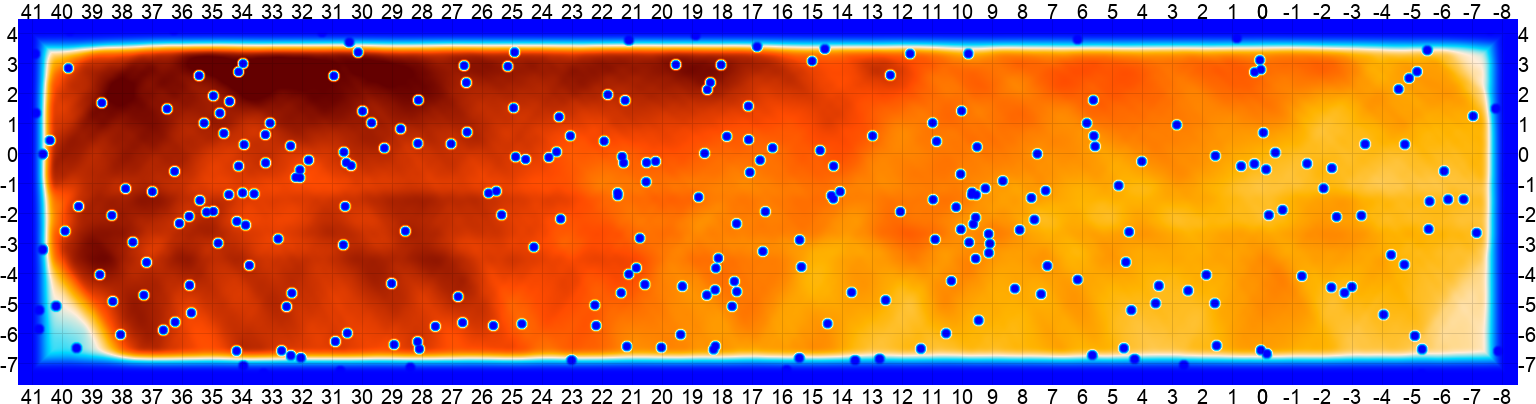

In [35]:
mask = enmap.read_fits("data/from_choi/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits")
plots = enplot.get_plots(mask, downgrade=4)
enplot.show(plots)

In [53]:
mask.shape

(1464, 6000)

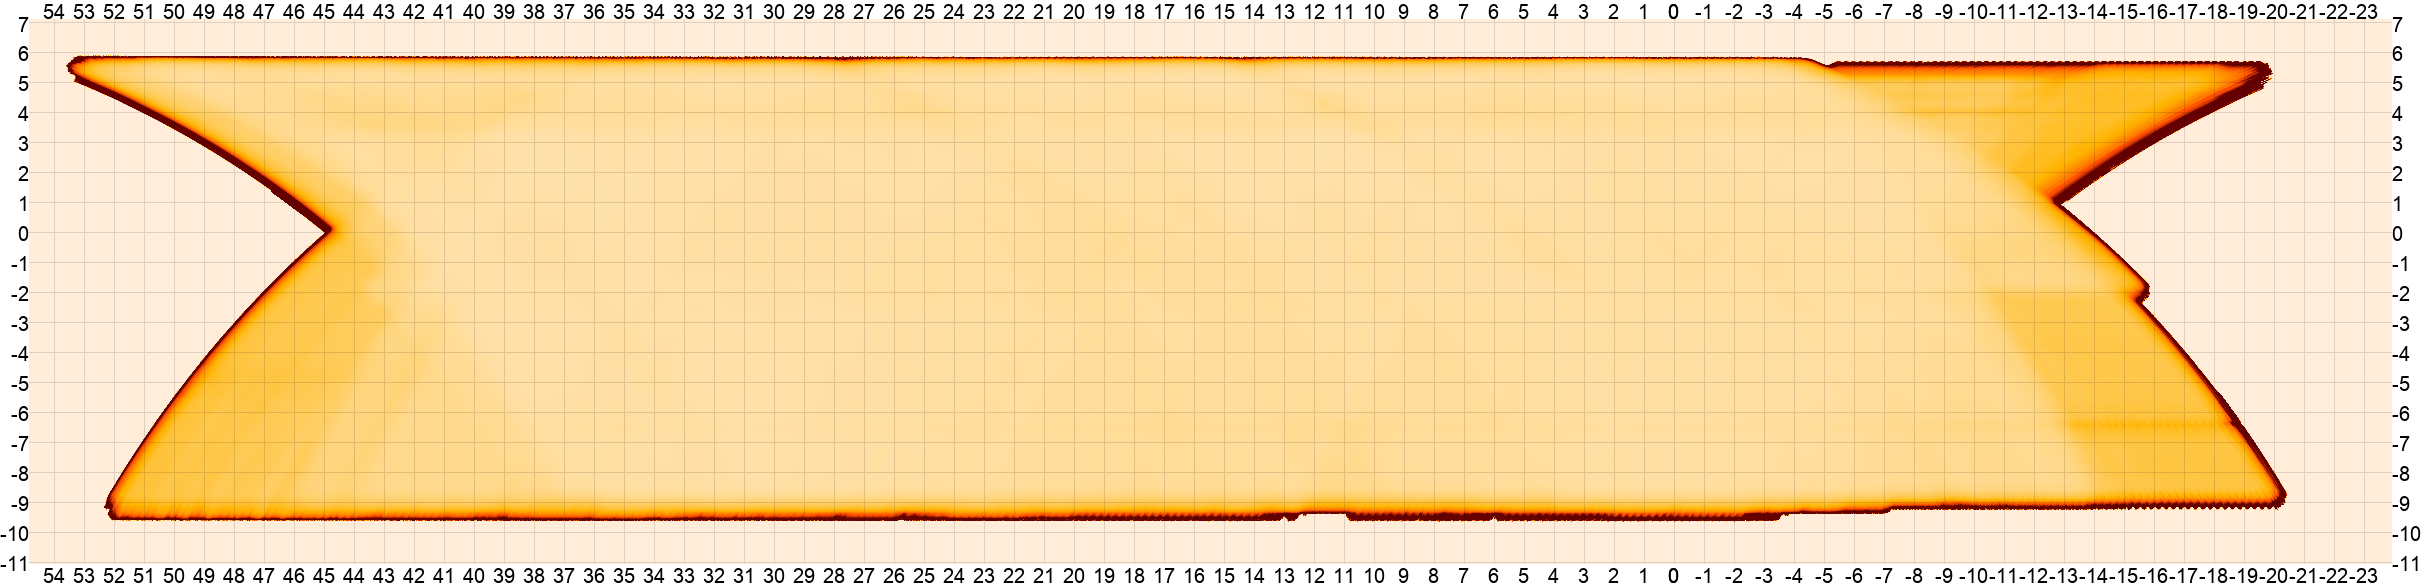

In [50]:
noise = enmap.read_fits("data/from_choi/maps/ACTPol_148_D56_pa2_f150_s14_4way_split3_noise.fits")
plots = enplot.get_plots( noise, downgrade=4, range=1000)
enplot.show(plots)

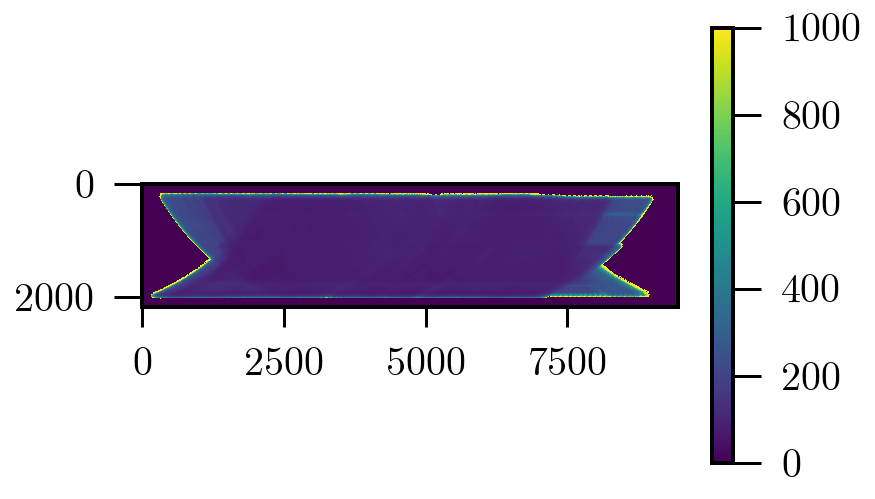

In [49]:
plt.imshow(noise, vmin=0, vmax=1000)
plt.colorbar()

In [58]:
mapname_head = "data/from_choi/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
maps = [enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits") for i in range(nsplits)]

In [64]:
m0 = maps[0]

In [80]:
print(m0.shape)
print(mask.shape)

(2182, 9455)
(1464, 6000)


In [75]:
diffs = np.array(m0.shape) - np.array(mask.shape)
diffs

array([ 718, 3455])

In [83]:
m0_chopped = m0[:,:]

In [84]:
m0_chopped.shape

(2182, 9455)

In [85]:
m0_chopped.wcs

car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[4728,1325]}

In [86]:
mask.wcs

car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3126,926]}

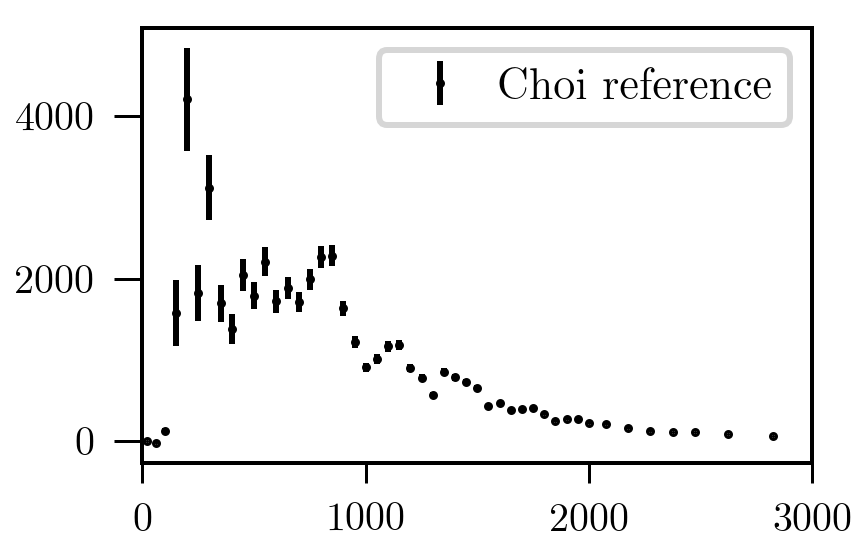

In [31]:
refps = ascii.read("data/from_choi/ps/deep56_s14_pa2_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01071187_output.txt")
plt.errorbar(refps['ell_bin'], refps['Dl_%s'], yerr=refps['Delta_Dl_%s'], fmt='k.', label="Choi reference" )
# plt.ylim(0,10000)
plt.xlim(0,3000)
plt.legend(frameon=True)

In [17]:
refps

ell_bin,Dl_%s,Delta_Dl_%s,(D)Nl
float64,float64,float64,float64
21.0,0.092232,0.224733,0.503423
60.5,-17.562717,7.528143,-19.188853
103.0,120.753484,36.334203,123.652923
150.5,1579.119367,404.434752,1878.03342
200.5,4208.547815,635.930535,2251.959868
250.5,1827.913338,343.353421,1976.047102
300.5,3120.361211,401.829472,1856.54261
350.5,1696.675836,229.187275,1344.593373
400.5,1380.145647,179.879388,1159.933631


# Compute Transfer Function

In [183]:
from pixell import powspec, curvedsky

camb_theory = powspec.read_spectrum("data/camb_theory.dat")
cltt = camb_theory[0,0,:3000]

apopath = 'data/from_choi/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
apo = enmap.read_map(apopath)

omap = curvedsky.rand_map(apo.shape,  apo.wcs, cltt, lmax=3000)
apod_pix=40
taper = enmap.apod(omap*0+1,apod_pix)

# plots = enplot.get_plots(omap, range=1000, downgrade=4)
# enplot.show(plots)

In [172]:
# nlb = 50
niter = 0 # NaMaster-CAR only supports niter=0

field0 = nmt.NmtField(taper * mask, [omap], wcs=mask.wcs, n_iter=niter)
cl_coupled = nmt.compute_coupled_cell(field0, field1)
lb = b.get_effective_ells()
w0 = nmt.NmtWorkspace()
w0.compute_coupling_matrix(field0,field1, b, n_iter=niter)

cl_coupled = nmt.compute_coupled_cell(field0, field1)
lb = b.get_effective_ells()
Cb = w0.decouple_cell(cl_coupled)

In [199]:
def get_ratio():
    
    omap = curvedsky.rand_map(apo.shape,  apo.wcs, cltt, lmax=3000)
    filtered_omap = enmap.samewcs(
                kfilter.get_map_kx_ky_filtered_pyfftw(
                    omap,d_th,kx,kx_apo,ky,ky_apo,unpixwin=unpixwin,zero_pad=False),
                omap) 

    field0 = nmt.NmtField(taper * mask, [omap], wcs=mask.wcs, n_iter=niter)
    cl_coupled = nmt.compute_coupled_cell(field0, field0)
    Cb = w0.decouple_cell(cl_coupled)

    field0 = nmt.NmtField(taper * mask, [filtered_omap], wcs=mask.wcs, n_iter=niter)
    cl_coupled = nmt.compute_coupled_cell(field0, field0)
    Cb_f = w0.decouple_cell(cl_coupled)
    return Cb[0] / Cb_f[0]

In [200]:
transfer_function_stack = [get_ratio() for i in range(9)]

In [206]:
fx_transfer_function = np.mean(transfer_function_stack, axis=0)
fx_transfer_function_delta = np.std(transfer_function_stack, axis=0)

In [209]:
fx_transfer_function[0] = 1
fx_transfer_function_delta[0] = 0

<ErrorbarContainer object of 3 artists>

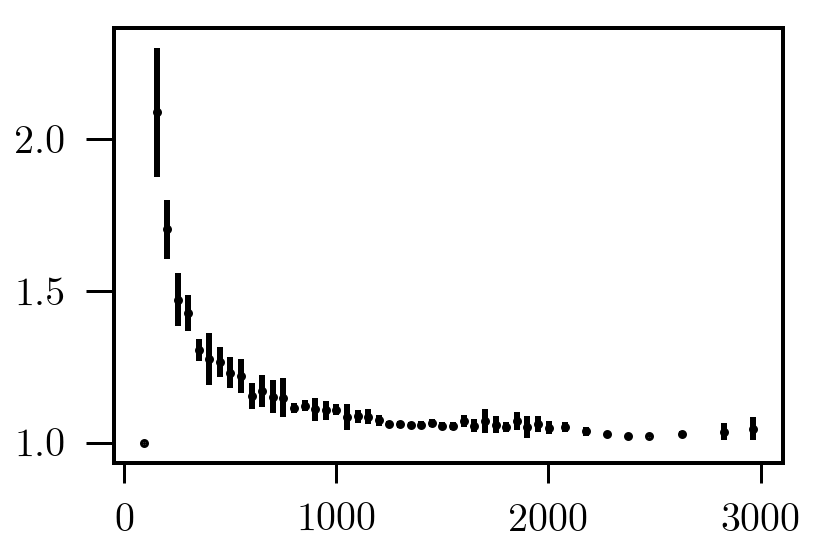

In [212]:
plt.errorbar( lb, fx_transfer_function, yerr=fx_transfer_function_delta, fmt='k.' )